### Predizer abundância de bactérias

**1.1 Importar bibliotecas básicas**

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**1.2 Importar o conjunto de dados**

In [109]:
df = pd.read_csv('Nigro.csv')

**1.3 Remover as colunas não utilizadas**

In [110]:
df = df.drop(['Date_(yyymmdd)', 'Local_Time_(HST)', 'Site', 'Latitude', 'Longitude', 
             'Bacteria (cells_per_mL)', 'vcgC_(gene_copies_per_mL)', 'TCBS_Total_(colonies_per_mL)', 
             'TCBS_Green_(colonies_per_mL)', 'TCBS_Yellow_(colonies_per_mL)',
              'CaV_Mauve_(colonies_per_mL)', 'CaV_Blue_(colonies_per_mL)', 'DNA_Yield_(ng_per_L_of_sample)'], axis=1)

**1.4 Tipos de dados**

In [112]:
#df.dtypes

**1.5 Estatística descritiva**

In [113]:
#df.describe()

**1.6 Problemas com valores ausentes**

**a) Há valores ausentes no dataframe?**

In [114]:
df.columns[df.isnull().any()].tolist()

[]

**b) Imputar np.nan a valores estranhos**

In [115]:
valores_invalidos = [-99.99, -100]
df = df.replace(valores_invalidos, np.nan)

**c) Substituir valores ausentes**

In [116]:
df = df.fillna(df.mean(numeric_only=True)).fillna(df.mode().iloc[0])

**1.7 Problemas com a variável resposta**

<Axes: xlabel='vvhA_(gene_copies_per_mL)', ylabel='Count'>

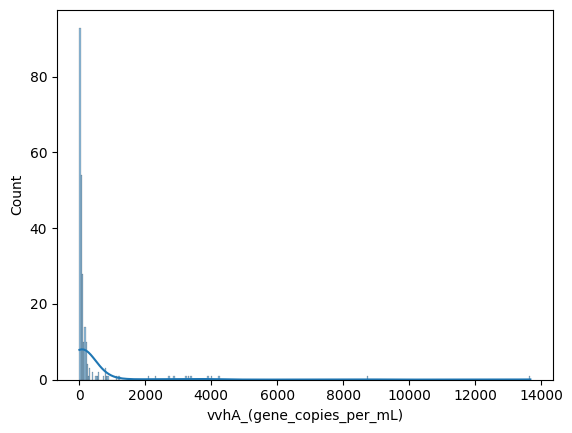

In [117]:
sns.histplot(data=df, x="vvhA_(gene_copies_per_mL)", kde=True)

**a) Renomear e transformar**

In [118]:
df.rename(columns={'vvhA_(gene_copies_per_mL)': 'vvhA_log+1'}, inplace=True)

df['vvhA_log+1'] = np.log1p(df['vvhA_log+1'])

<Axes: xlabel='vvhA_log+1', ylabel='Count'>

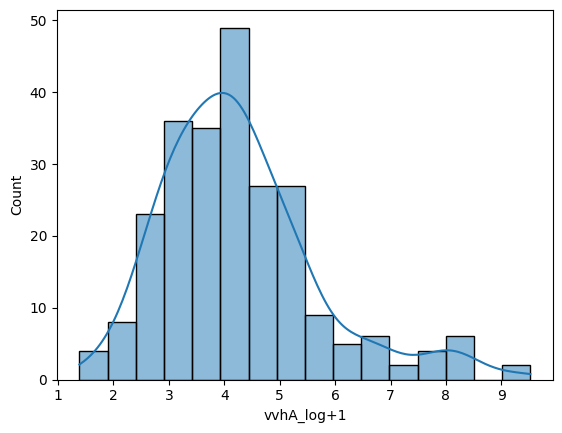

In [119]:
sns.histplot(data=df, x="vvhA_log+1", kde=True)

**1.8 Acessar multicolinearidade**

**Dados categóricos**

In [120]:
from scipy.stats import chi2_contingency

**a) Criar tabela de contigência**

In [121]:
crosstab = pd.crosstab(df['Site_Type'], 
df['Nominal_Season'], margins=True, margins_name="subtotal")

print(crosstab)

Nominal_Season        Dry  Rainy  subtotal
Site_Type                                 
Canal_Lower            29     20        49
Canal_Lower_Harbor      8      7        15
Canal_Mid              16     14        30
Canal_Upper            45     34        79
Canal_Upper_Drainage    8      7        15
Stream_Makiki          12      9        21
Stream_Manoa           21     13        34
subtotal              139    104       243


**b) Realizar teste de chi-quadrado**

In [122]:
chi, p, dof, expected = chi2_contingency(crosstab)

In [123]:
print(p)

0.9999998679640332


In [124]:
print(chi)

0.7364230180314051


**Dados quantitativos**

In [125]:
# Vamos remover as  variáveis categóricas
df_numerico = df.drop(['Site_Type', 'Nominal_Season'], axis = 1)

**a) Matriz de correlação**

Text(0.5, 1.0, 'Matriz de correlação Vibrio')

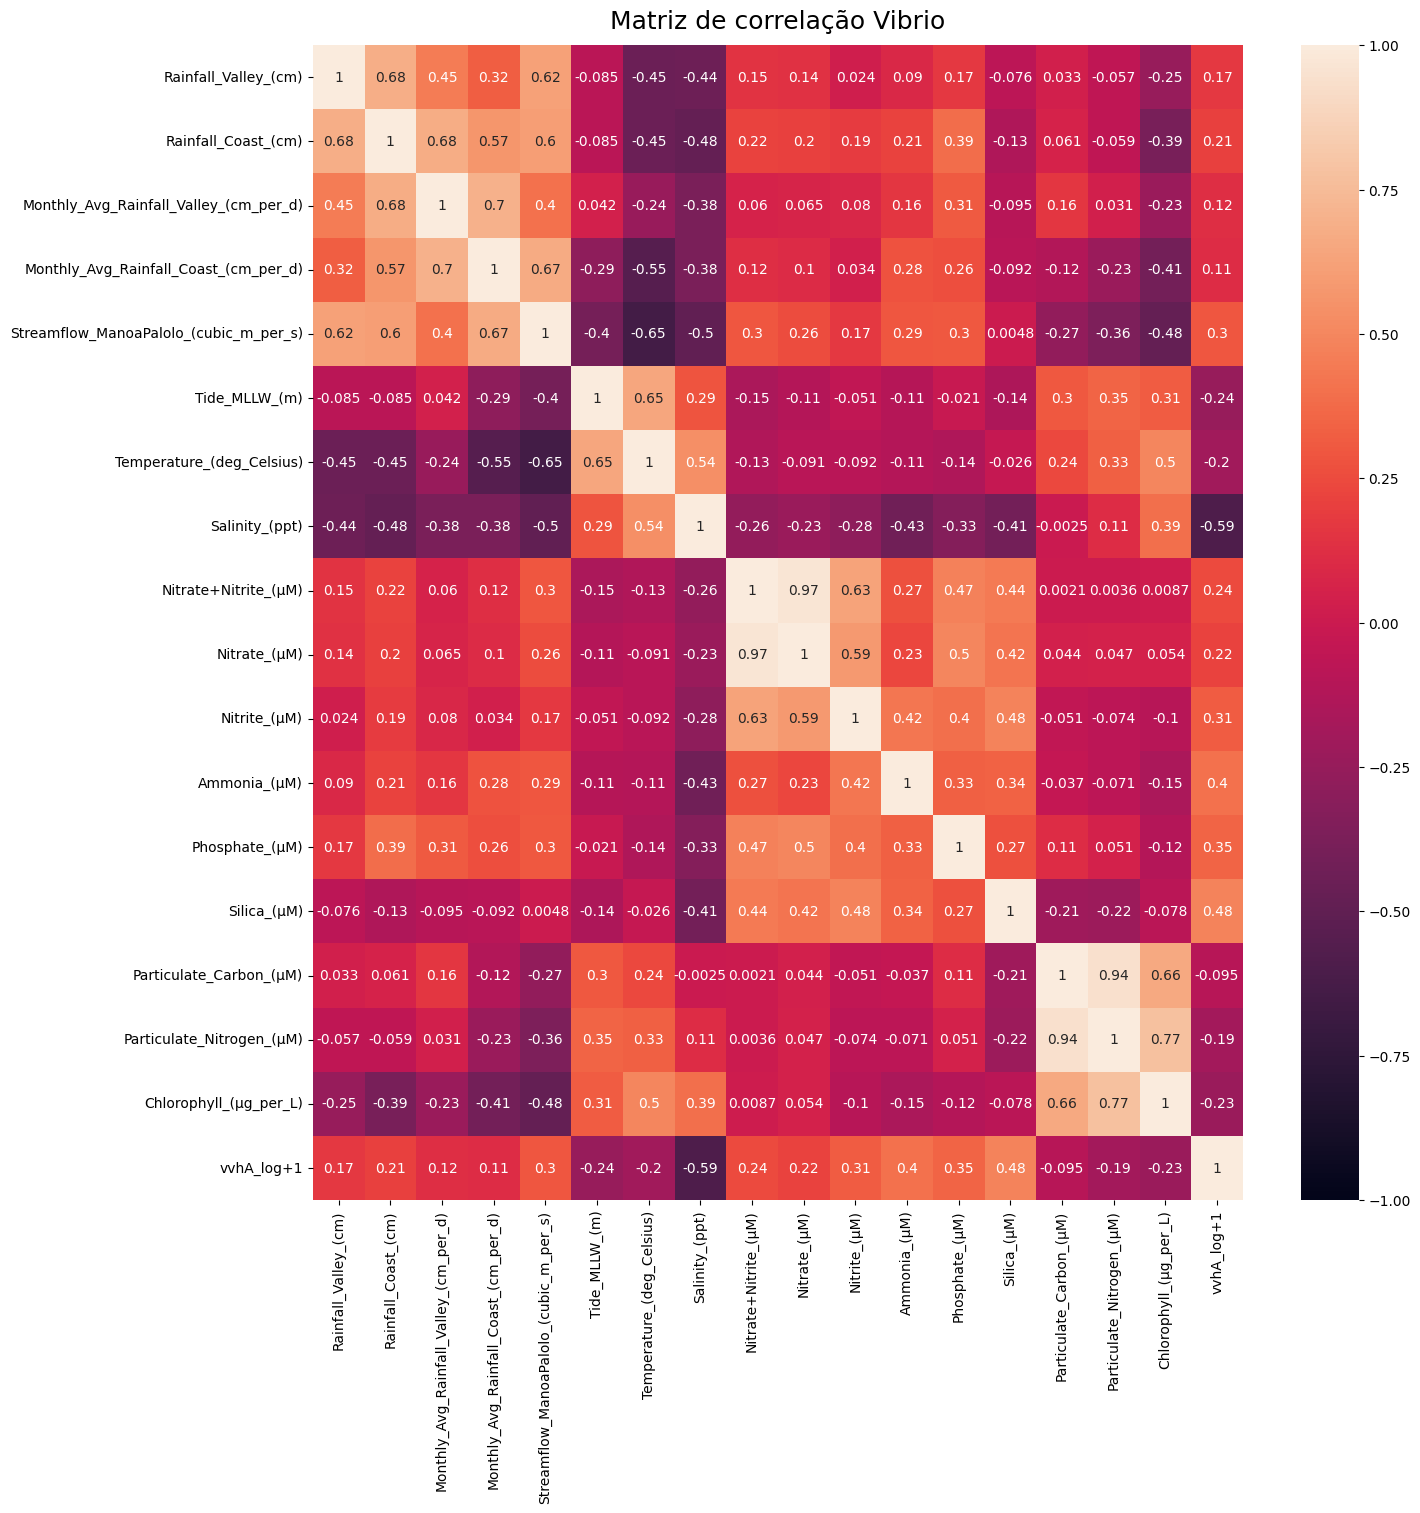

In [126]:
plt.figure(figsize = (15, 15))
heatmap = sns.heatmap(df_numerico.corr(method = 'spearman'), vmin = -1, vmax = 1, annot = True)
heatmap.set_title('Matriz de correlação Vibrio', fontdict = {'fontsize' : 18}, pad = 12)

**b)VIF**

In [127]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [128]:
# Criamos um dataframe vazio VIF:
vif_data = pd.DataFrame()

# Adicionamos nossos dados ao dataframe
vif_data['Feature'] = df_numerico.columns

# Calculamos o VIF
vif_data["VIF"] = [variance_inflation_factor(df_numerico.values, i)
                          for i in range(len(df_numerico.columns))]
print(vif_data)

                                   Feature         VIF
0                     Rainfall_Valley_(cm)    8.441472
1                      Rainfall_Coast_(cm)   28.397355
2   Monthly_Avg_Rainfall_Valley_(cm_per_d)   35.654119
3    Monthly_Avg_Rainfall_Coast_(cm_per_d)   13.645057
4   Streamflow_ManoaPalolo_(cubic_m_per_s)   41.673663
5                            Tide_MLLW_(m)    3.707219
6                Temperature_(deg_Celsius)  136.096103
7                           Salinity_(ppt)   44.528413
8                     Nitrate+Nitrite_(µM)  219.496682
9                             Nitrate_(µM)  214.742879
10                            Nitrite_(µM)    7.098678
11                            Ammonia_(µM)    7.323259
12                          Phosphate_(µM)    4.771592
13                             Silica_(µM)    9.447322
14                 Particulate_Carbon_(µM)  170.727382
15               Particulate_Nitrogen_(µM)  200.652976
16                  Chlorophyll_(µg_per_L)    5.810933
17        

**Dataframe final**

In [129]:
df_final = df.drop(['Nominal_Season', 'Streamflow_ManoaPalolo_(cubic_m_per_s)', 
                    'Nitrate+Nitrite_(µM)', 'Nitrate_(µM)', 'Particulate_Carbon_(µM)',
                    'Particulate_Nitrogen_(µM)', 'Monthly_Avg_Rainfall_Valley_(cm_per_d)',
                    'Monthly_Avg_Rainfall_Coast_(cm_per_d)', 'Rainfall_Coast_(cm)'], axis = True)

**1.9 Separar os dados em X e y**

In [130]:
target = 'vvhA_log+1'
X = df_final.drop(columns = target)
y = df_final[target].values

**1.10 Codificação de variáveis categóricas**

In [131]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [132]:
#Lista de variáveis categóricas

colunas_categoricas =  ['Site_Type']

# Aplicação do One Hot Endoding

ct = ColumnTransformer(

[('one_hot_encoder', OneHotEncoder(drop = 'first', sparse_output = False), colunas_categoricas)], 
    remainder = 'passthrough'
    
)

# Aplicamos a transformação e salvamos sob X_array
X_array = ct.fit_transform(X)

# Recuperamos os nomes das colunas transformadas
colunas_finais = ct.get_feature_names_out()

# Convertemos para dataframe mantendo os índices originais
X_df = pd.DataFrame(X_array, columns = colunas_finais, index= X.index)

**1.11 Separar os dados em conjunto de treinamento e de teste**

In [133]:
from sklearn.model_selection import train_test_split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state=42)

**1.12 Padronização dos dados numéricos**

In [135]:
from sklearn.preprocessing import StandardScaler

In [136]:
# 1. Selecionar colunas numéricas contínuas, ou seja, que não são dummies (OneHotEncoder)

colunas_numericas = [col for col in X_df.columns if not col.startswith('one_hot_encoder__')]

# 2. Criar o ColumnTransformer usando os nomes diretamente

ct = ColumnTransformer(
    [('escalar', StandardScaler(), colunas_numericas)],
    remainder='passthrough'
)

# 3. Ajustar e transformar os dados de treino
X_train_scaled = ct.fit_transform(X_train)

# 4. Aplicar a mesma transformação aos dados de teste
X_test_scaled = ct.transform(X_test)

# 5. Obter os nomes finais das colunas após transformação
columns_final_scaled = ct.get_feature_names_out()

# 6. Converter em DataFrames com os nomes corretos
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns_final_scaled, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns_final_scaled, index=X_test.index)

#### Regressão linear

In [137]:
from sklearn.linear_model import LinearRegression

**2.1 Criar o modelo e treinar**

In [138]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression()

**2.2 Obter os valores preditos para y**

In [139]:
y_pred_train = lm.predict(X_train_scaled)
y_pred_test = lm.predict(X_test_scaled)

**2.3 Validação cruzada**

In [140]:
from sklearn.model_selection import cross_val_score

In [141]:
cv_lm = cross_val_score(estimator = lm, X = X_train_scaled, y = y_train, cv = 5)

**2.4 Calcular R2**

In [154]:
# R2 para o conjunto de treinamento
r2_train = lm.score(X_train_scaled, y_train)

# R2 para o conjunto de teste
r2_test = lm.score(X_test_scaled, y_test)

print(f"Coeficiente de determinação para o conjunto de treinamento: {r2_train}")
print(f"Coeficiente de determinação para o conjunto de teste: {r2_test}")

Coeficiente de determinação para o conjunto de treinamento: 0.5683387274631932
Coeficiente de determinação para o conjunto de teste: 0.5410692497616426


**2.5 Vamos obter o número de observações e o número de variáveis**

In [143]:
# Número de observações do conjunto de treinamento
n_train = X_train_scaled.shape[0]
print(n_train)

# Número de observações no conjunto de teste (número de linhas)
n_test = X_test_scaled.shape[0]
print(n_test)

# Número de variáveis
p = X_test_scaled.shape[1]
print(p)

194
49
15


**2.6 Calcular R2 ajustado**

In [155]:
# R2 ajustado do conjunto de treinamento
lm_r2_ajustado_train = 1-(1-r2_train)*(n_train-1)/(n_train-p-1)

# R2 ajustado do conjunto de teste
lm_r2_ajustado_test = 1-(1-r2_test)*(n_test-1)/(n_test-p-1)

print(f"Coeficiente de determinação ajustado para o conjunto de treinamento: {lm_r2_ajustado_train}")
print(f"Coeficiente de determinação ajustado para o conjunto de teste: {lm_r2_ajustado_test}")

Coeficiente de determinação ajustado para o conjunto de treinamento: 0.5319627775303163
Coeficiente de determinação ajustado para o conjunto de teste: 0.3324643632896619


**2.7 Raiz quadrada do erro quadrado médio**

In [145]:
from sklearn.metrics import mean_squared_error

In [156]:
# Raiz quadrada do erro quadrado médio do conjunto de treinamento
lm_RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
lm_RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Raiz quadrada do erro quadrado médio para o conjunto de treinamento: {lm_RMSE_train}")
print(f"Raiz quadrada do erro quadrado médio para o conjunto de teste: {lm_RMSE_test}")

Raiz quadrada do erro quadrado médio para o conjunto de treinamento: 0.9236248548438758
Raiz quadrada do erro quadrado médio para o conjunto de teste: 0.9517507104332731


**2.8 R2 médio da validação cruzada**

In [157]:
lmCV_R2 = cv_lm.mean()
print(lmCV_R2)

0.4005372157727519


Text(0.5, 1.0, 'Regressão linear com todas as variáveis')

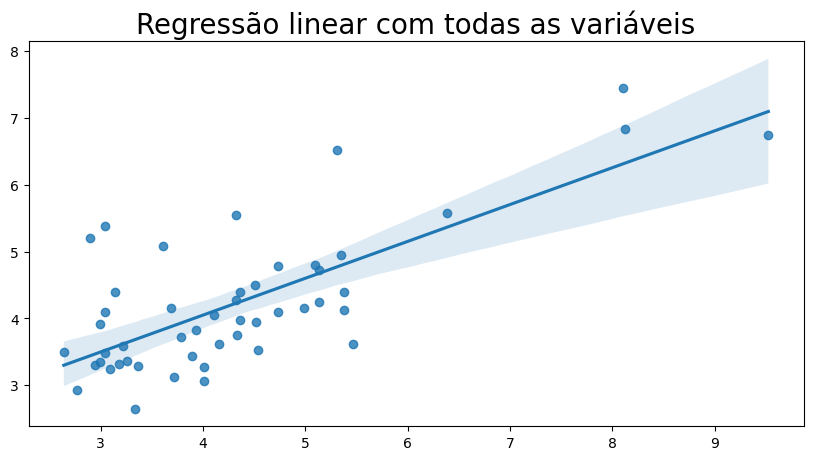

In [158]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred_test)
plt.title('Regressão linear com todas as variáveis', fontsize = 20)

### Regressão com bosques aleatórios

In [149]:
from sklearn.ensemble import RandomForestRegressor

**3.1 Criar o modelo e treinar**

In [159]:
RandomForest_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
RandomForest_reg.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

**3.2 Obter os valores preditos para y**

In [160]:
y_pred_train_rf = RandomForest_reg.predict(X_train_scaled)
y_pred_test_rf = RandomForest_reg.predict(X_test_scaled)

**3.3 Validação cruzada**

In [161]:
cv_rf = cross_val_score(estimator = RandomForest_reg, X = X_train_scaled, y = y_train, cv = 5)

**3.4 Calculando R2**

In [162]:
# R2 para o conjunto de treinamento
r2_rf_train = RandomForest_reg.score(X_train_scaled, y_train)

# R2 para o conjunto de teste
r2_rf_test = RandomForest_reg.score(X_test_scaled, y_test)

print(f"Coeficiente de determinação para o conjunto de treinamento: {r2_rf_train}")
print(f"Coeficiente de determinação para o conjunto de teste: {r2_rf_test}")

Coeficiente de determinação para o conjunto de treinamento: 0.9362220683710918
Coeficiente de determinação para o conjunto de teste: 0.6111172673890464


**3.5 R2 ajustado**

In [163]:
# R2 ajustado do conjunto de treinamento
rf_r2_ajustado_train = 1-(1-r2_rf_train)*(n_train-1)/(n_train-p-1)

# R2 ajustado do conjunto de teste
rf_r2_ajustado_test = 1-(1-r2_rf_test)*(n_test-1)/(n_test-p-1)

print(f"Coeficiente de determinação ajustado para o conjunto de treinamento: {rf_r2_ajustado_train}")
print(f"Coeficiente de determinação ajustado para o conjunto de teste: {rf_r2_ajustado_test}")

Coeficiente de determinação ajustado para o conjunto de treinamento: 0.9308475235709028
Coeficiente de determinação ajustado para o conjunto de teste: 0.434352388929522


**3.6 Raiz quadrada do erro quadrado médio**

In [164]:
# Raiz quadrada do erro quadrado médio do conjunto de treinamento
rf_RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
rf_RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

print(f"Raiz quadrada do erro quadrado médio para o conjunto de treinamento: {rf_RMSE_train}")
print(f"Raiz quadrada do erro quadrado médio para o conjunto de teste: {rf_RMSE_test}")

Raiz quadrada do erro quadrado médio para o conjunto de treinamento: 0.3550252838042237
Raiz quadrada do erro quadrado médio para o conjunto de teste: 0.8761106516569955


**3.7 R2 médio da validação cruzada**

In [165]:
rfCV_R2 = cv_rf.mean()
print(rfCV_R2)

0.5036794311655417


### Modelos lineares com regularização

### Regressão Ridge

**OBS: Vamos refazer a divisão dos dados porque vamos trabalhar com todas as variáveis**

**Separar X e y no dataframe original**

In [166]:
target = 'vvhA_log+1'
X = df.drop(columns = target)
y = df[target].values

**Codificação de TODAS as variáveis categóricas**

In [167]:
#Lista de variáveis categóricas

colunas_categoricas =  ['Site_Type', 'Nominal_Season']

# Aplicação do One Hot Endoding

ct = ColumnTransformer(

[('one_hot_encoder', OneHotEncoder(drop = 'first', sparse_output = False), colunas_categoricas)], 
    remainder = 'passthrough'
    
)

# Aplicamos a transformação e salvamos sob X_array
X_array = ct.fit_transform(X)

# Recuperamos os nomes das colunas transformadas
colunas_finais = ct.get_feature_names_out()

# Convertemos para dataframe mantendo os índices originais
X_df = pd.DataFrame(X_array, columns = colunas_finais, index= X.index)

**Separar o conjunto de dados em treinamento e teste**

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state=42)

**Padronizar TODAS as variáveis quantitativas**

In [169]:
colunas_numericas = [col for col in X_df.columns if not col.startswith('one_hot_encoder__')]

ct = ColumnTransformer(
    [('escalar', StandardScaler(), colunas_numericas)],
    remainder='passthrough'
)

# 3. Ajustar e transformar os dados de treino
X_train_scaled = ct.fit_transform(X_train)

# 4. Aplicar a mesma transformação aos dados de teste
X_test_scaled = ct.transform(X_test)

# 5. Obter os nomes finais das colunas após transformação
columns_final_scaled = ct.get_feature_names_out()

# 6. Converter em DataFrames com os nomes corretos
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns_final_scaled, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns_final_scaled, index=X_test.index)

**4.1 Treinar e ajustar o modelo**

In [170]:
from sklearn.linear_model import Ridge

In [171]:
ridge_reg = Ridge(alpha=100, solver="auto")
ridge_reg.fit(X_train_scaled, y_train)

Ridge(alpha=100)

**4.2 Predizer valores de y**

In [172]:
y_pred_train_ridge = ridge_reg.predict(X_train_scaled)
y_pred_test_ridge = ridge_reg.predict(X_test_scaled)

**4.3 Validação cruzada**

In [173]:
cv_ridge = cross_val_score(estimator = ridge_reg, X = X_train, y = y_train, cv = 10)

**4.4 Calcular R2**

In [174]:
# R2 para o conjunto de treinamento
r2_ridge_train = ridge_reg.score(X_train_scaled, y_train)

# R2 para o conjunto de teste
r2_ridge_test = ridge_reg.score(X_test_scaled, y_test)

print(f"Coeficiente de determinação para o conjunto de treinamento: {r2_ridge_train}")
print(f"Coeficiente de determinação para o conjunto de teste: {r2_ridge_test}")

Coeficiente de determinação para o conjunto de treinamento: 0.5325275407749357
Coeficiente de determinação para o conjunto de teste: 0.5346331545532467


**4.5 Obter o número de variáveis**

In [175]:
#Número de variáveis
p_ridge = X_test_scaled.shape[1]
print(p)

15


**4.6 R2 ajustado**

In [176]:
# R2 ajustado do conjunto de treinamento
ridge_r2_ajustado_train = 1-(1-r2_ridge_train)*(n_train-1)/(n_train-p_ridge-1)

# R2 ajustado do conjunto de teste
ridge_r2_ajustado_test = 1-(1-r2_ridge_test)*(n_test-1)/(n_test-p_ridge-1)

print(f"Coeficiente de determinação ajustado para o conjunto de treinamento: {ridge_r2_ajustado_train}")
print(f"Coeficiente de determinação ajustado para o conjunto de teste: {ridge_r2_ajustado_test}")

Coeficiente de determinação ajustado para o conjunto de treinamento: 0.46614091934652424
Coeficiente de determinação ajustado para o conjunto de teste: 0.06926630910649345


**4.7 Raiz quadrada do erro quadrado médio**

In [178]:
# Raiz quadrada do erro quadrado médio do conjunto de treinamento
ridge_RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train_ridge))
ridge_RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))

print(f"Raiz quadrada do erro quadrado médio para o conjunto de treinamento: {ridge_RMSE_train}")
print(f"Raiz quadrada do erro quadrado médio para o conjunto de teste: {ridge_RMSE_test}")

Raiz quadrada do erro quadrado médio para o conjunto de treinamento: 0.9611741513178279
Raiz quadrada do erro quadrado médio para o conjunto de teste: 0.958401203013195


**4.8 R2 médio da validação cruzada**

In [179]:
print("R2 da validação cruzada: ", round(cv_ridge.mean(),4))

R2 da validação cruzada:  0.3812


**4.9 Gráfico geral**

Text(0.5, 1.0, 'Regressão com regularização - Ridge')

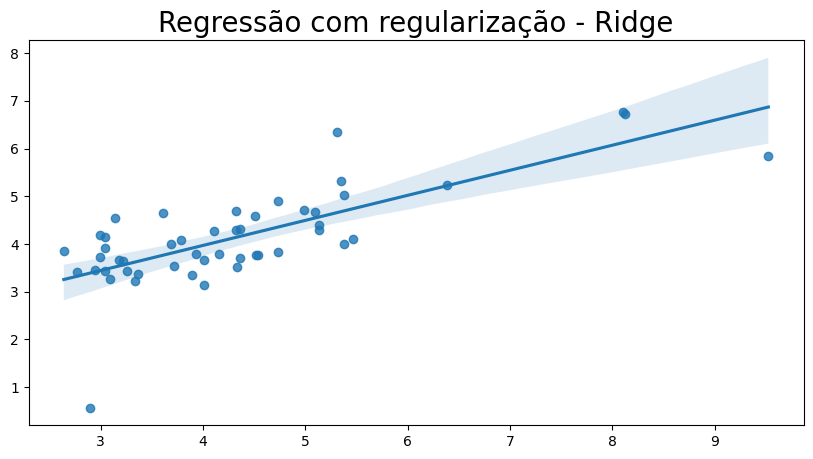

In [180]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred_test_ridge)
plt.title('Regressão com regularização - Ridge', fontsize = 20)

### Regressão Lasso

**5.1 Qual o seria o melhor valor de alfa para treinar o modelo**

In [181]:
from sklearn.linear_model import LassoCV

In [182]:
lasso_cv = LassoCV(alphas=[0.01, 0.1, 0.2, 0.5, 1, 5, 10], cv=5)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Melhor valor de alfa encontrado: {lasso_cv.alpha_}")

Melhor valor de alfa encontrado: 0.01


**5.2 Treinar e ajustar o modelo**

In [105]:
from sklearn.linear_model import Lasso

In [185]:
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

**5.3 Predizer valores de y**

In [186]:
y_pred_train_lasso = lasso_reg.predict(X_train_scaled)
y_pred_test_lasso = lasso_reg.predict(X_test_scaled)

**5.3 Quais variáveis permaneceram no modelo?**

In [187]:
coeficientes = pd.Series(lasso_reg.coef_, index=X_train_scaled.columns)

# Filtrar apenas os coeficientes diferentes de zero
variaveis_mantidas = coeficientes[coeficientes != 0]

# Mostrar nomes das variáveis e seus coeficientes
print(variaveis_mantidas)

escalar__remainder__Rainfall_Coast_(cm)                       0.209560
escalar__remainder__Monthly_Avg_Rainfall_Valley_(cm_per_d)    0.275079
escalar__remainder__Monthly_Avg_Rainfall_Coast_(cm_per_d)    -0.554487
escalar__remainder__Tide_MLLW_(m)                            -0.183611
escalar__remainder__Temperature_(deg_Celsius)                 0.396040
escalar__remainder__Salinity_(ppt)                           -0.912474
escalar__remainder__Nitrite_(µM)                              0.242113
escalar__remainder__Ammonia_(µM)                              0.222459
escalar__remainder__Silica_(µM)                               0.065588
escalar__remainder__Particulate_Carbon_(µM)                  -0.447708
escalar__remainder__Chlorophyll_(µg_per_L)                    0.277337
remainder__one_hot_encoder__Site_Type_Canal_Lower_Harbor      0.017164
remainder__one_hot_encoder__Site_Type_Canal_Mid              -0.198681
remainder__one_hot_encoder__Site_Type_Canal_Upper            -0.067765
remain

**5.4 Calcular R2**

In [188]:
# R2 para o conjunto de treinamento
r2_lasso_train = lasso_reg.score(X_train_scaled, y_train)

# R2 para o conjunto de teste
r2_lasso_test = lasso_reg.score(X_test_scaled, y_test)

print(f"Coeficiente de determinação para o conjunto de treinamento: {r2_lasso_train}")
print(f"Coeficiente de determinação para o conjunto de teste: {r2_lasso_test}")

Coeficiente de determinação para o conjunto de treinamento: 0.6450446428988741
Coeficiente de determinação para o conjunto de teste: 0.29917784684270576


**5.5 Gráfico geral**

Text(0.5, 1.0, 'Modelo de Regressão Lasso')

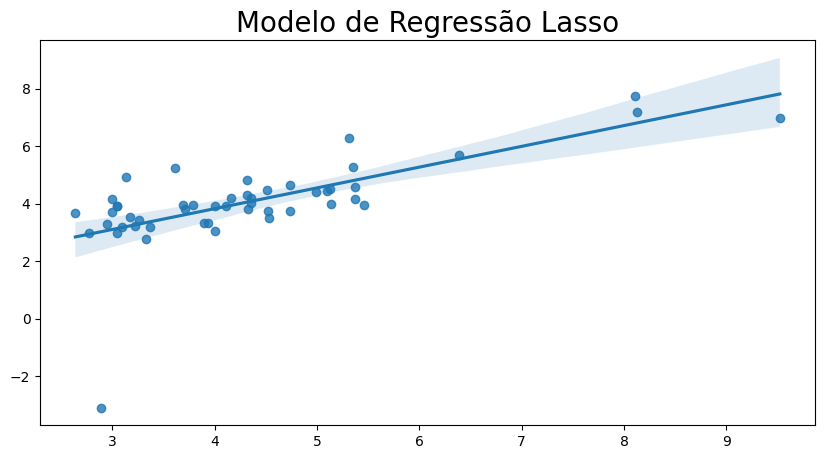

In [191]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred_test_lasso)
plt.title('Modelo de Regressão Lasso', fontsize = 20)

### Regressão Bayesiana

**6.1 Treinar e ajustar o modelo**

In [192]:
from sklearn.linear_model import BayesianRidge

In [193]:
BayesianRidge_reg = BayesianRidge()
BayesianRidge_reg.fit(X_train_scaled, y_train)

BayesianRidge()

**6.2 Predizer os valores de y**

In [195]:
y_pred_train_bayesian = BayesianRidge_reg.predict(X_train_scaled)
y_pred_test_bayesian = BayesianRidge_reg.predict(X_test_scaled)

**6.3 Validação cruzada**

In [196]:
cv_BayesianRidge = cross_val_score(estimator = BayesianRidge_reg, X = X_train_scaled, y = y_train, cv = 10)

**6.4 Calcular R2**

In [197]:
r2_train_bayesian = BayesianRidge_reg.score(X_train_scaled, y_train)
r2_test_bayesian = BayesianRidge_reg.score(X_test_scaled, y_test)

print(f"R² treino: {r2_train_bayesian:.3f}")
print(f"R² teste: {r2_test_bayesian:.3f}")

R² treino: 0.642
R² teste: 0.341


**6.5 Gráfico do modelo**

Text(0.5, 1.0, 'Bayesian Ridge Regression model')

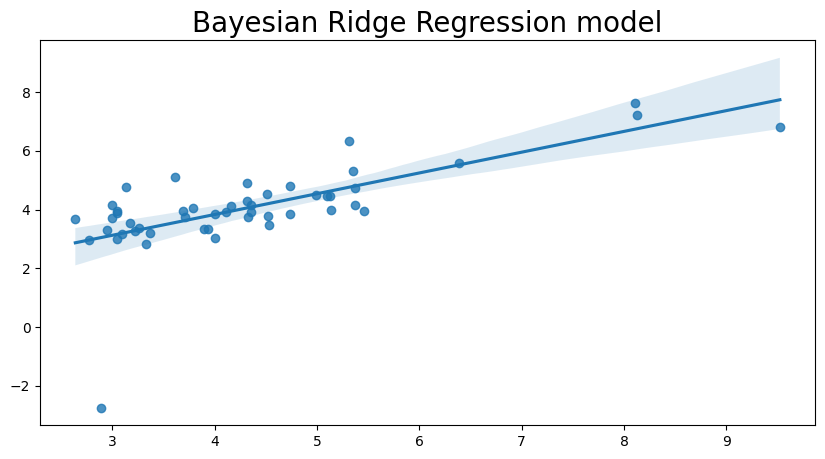

In [198]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred_test_bayesian)
plt.title('Bayesian Ridge Regression model', fontsize = 20)